In [719]:
import pandas as pd
import numpy as np
import sklearn

# Comparing machine learning model scoring based feature selection with traditional statistical approaches for clustering bladder cancer stages using label free data independent LC/MS-MS proteomic data

## 1. Preprocess and transform the data file such that we get a sample by protein matrix. The dataset uses UniProt protein IDs in the original Protein.csv file. We rename the data matrix with protein names using the given Fasta File from the source which has the mapping of  protein IDs to their respective protein name. The two functions below will handle this.

In [720]:
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

def preprocessData(proteinData):
    
    df = pd.read_csv(proteinData,header=2)
    
    df = df.drop(['Peptide count', 'Unique peptides', 'Confidence score',
       'Anova (p)', 'q Value', 'Max fold change', 'Power',
       'Highest mean condition', 'Lowest mean condition','Mass','Description'],axis=1)
    
    df = df.set_index(df.columns[0])
    df = df.iloc[:,:18]
    df = df.T
    df = df.dropna(axis='columns')
    
    df = df.loc[:,~df.columns.duplicated()].copy()
    
    cols = df.columns
    sc = StandardScaler()
    dfScaled = pd.DataFrame(sc.fit_transform(df), columns=cols)
    dfScaled.index = df.index
    
    classes = []
    
    for i in range(3):
        for j in range(6):
            classes.append("Stage"+" "+str(i+1))
            
    dfScaled["Class"] = classes
    
    renameIndex = {}
    for idx,name in enumerate(dfScaled.index):
        renameIndex[name] = "Sample"+" "+name.split("_")[1]+" "+dfScaled.iloc[idx,-1]

    dfScaled = dfScaled.rename(index=renameIndex)
    
    return dfScaled


def convertUniProtToProteinName(df,file):
    
    headers = defaultdict(str)
    with open(file) as file:
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                header = line.split("|")
                sequenceInfo = header[2].split(" ")
                geneCode = header[1]
                for i in sequenceInfo:
                    if "GN=" in i:
                        headers[geneCode] = i.split("=")[1]
                        
      
    codeNames = [ codeName.split(";")[0] if ";" in codeName else codeName for codeName in df.columns ]
    geneNames = []

    for n in codeNames:
        if n not in headers:
            geneNames.append(n)
        else:
            geneNames.append(headers[n])
    
    df.columns = geneNames
    
    return df

In [721]:
df = preprocessData("/Users/zulfi/Downloads/Protein.csv")
df = convertUniProtToProteinName(df,"/Users/zulfi/Desktop/uniprot_Human_all_30112020.txt")

## 2. Looking at the sample correlations, we can see that samples at stage 1 are anti-correlated to both stage 2 and stage 3, but stage 2 and stage 3 samples are mildly correlated in some instances.

Text(0.5, 1.0, 'Sample Correlations')

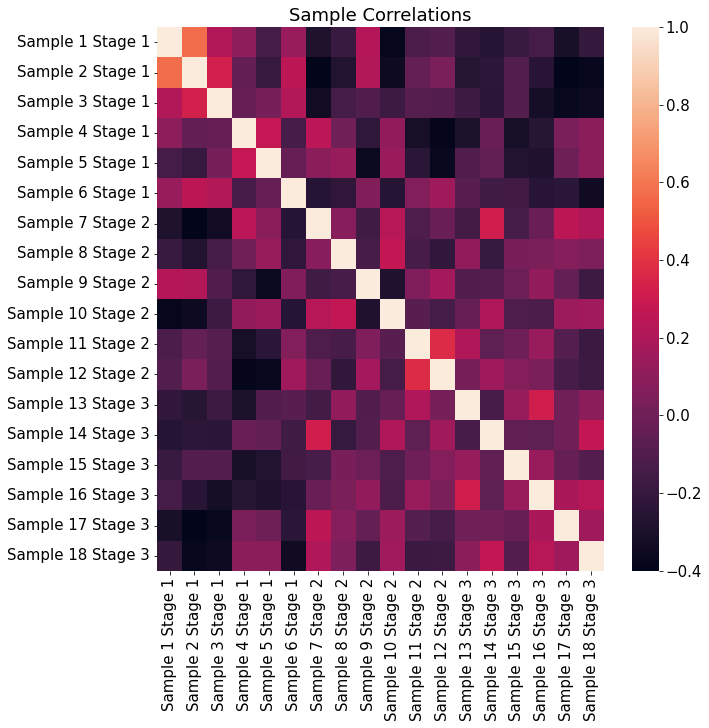

In [743]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15

sns.heatmap(df.iloc[:,:-1].T.corr())
plt.title("Sample Correlations")

## 3. Initial Feature Selection Strategy: The goal is to use different feature selection methods to filter down to proteins that contribute to each stage. We want to compare traditional statistical approaches with feature selection methods that are based on the machine learning algorithm. 

### * For the below methods except the Kruskal-Wallis test, a one vs one approach will be taken, that is, we apply the statistical test or fitted classifier between stage 1 and stage 2 samples, and another statistical test or fitted classifier between stage 2 and stage 3 samples.

### * For the traditional approaches, we use 2 statistical approaches, the Kruskal-Wallis test and the Mann Whitney U-Test since these are non-parameteric with no assumptions which is appropriate for the small sample size. We will use multiple testing correction with Benjamini-Hochberg procedure and select proteins with adjusted p-values that are in the top 0.05th lowest quantile.

### *  For the Linear SVC we use the weights of the features that are learned during optimization to minimize the classification error while maximizing the margin for feature selection. For Random Forest Classifier, we use the Gini importance for features, where a useful feature will split mixed labels into single label nodes. For each model scoring mechanism, either feature weights or feature Gini importances, the top 60 proteins are returned, 30 from each one vs one test that is, top 30 proteins between stage 1 and stage 2 and top 30 proteins between stage 2 and stage 3.

### See the four functions for each strategy below.

In [745]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from scipy import stats
from statsmodels.stats.multitest import multipletests
from operator import itemgetter
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def oneVsOneLinearSVC(df,nFeatures):

    grade1vs2 = df[df["Class"].isin(["Stage 1","Stage 2"])]
    grade1vs2Vars,grade1vs2Labels = grade1vs2.iloc[:,:-1],grade1vs2.iloc[:,-1]

    svc1 = SVC(kernel="linear").fit(grade1vs2Vars,grade1vs2Labels)

    sortedProteinsSVC1 = sorted(list(zip(grade1vs2.columns,svc1.coef_[0])),key=lambda x: x[1],reverse=True)

    grade2vs3 = df[df["Class"].isin(["Stage 2","Stage 3"])]
    grade2vs3Vars,grade2vs3Labels = grade2vs3.iloc[:,:-1],grade2vs3.iloc[:,-1]

    svc2 = SVC(kernel="linear").fit(grade2vs3Vars,grade2vs3Labels)

    sortedProteinsSVC2 = sorted(list(zip(grade2vs3.columns,svc2.coef_[0])),key=lambda x: x[1],reverse=True)
    
    genesToInclude = [] 
    
    sharedGenes = list(set([i[0] for i in sortedProteinsSVC1[:nFeatures]]+[i[0] for i in sortedProteinsSVC2[:nFeatures]]))
    
    dfFilt = df.loc[:,sharedGenes]
    
    return dfFilt

def oneVsOneRFC(df,nFeatures):
    
    grade1vs2 = df[df["Class"].isin(["Stage 1","Stage 2"])]
    grade1vs2Vars,grade1vs2Labels = grade1vs2.iloc[:,:-1],grade1vs2.iloc[:,-1]

    rfc1 = RandomForestClassifier(n_estimators=100, random_state=42).fit(grade1vs2Vars,grade1vs2Labels)

    sortedProteinsRFC1 = sorted(list(zip(grade1vs2.columns,rfc1.feature_importances_)),key=lambda x: x[1],reverse=True)

    grade2vs3 = df[df["Class"].isin(["Stage 2","Stage 3"])]
    grade2vs3Vars,grade2vs3Labels = grade2vs3.iloc[:,:-1],grade2vs3.iloc[:,-1]

    rfc2 = RandomForestClassifier(n_estimators=100, random_state=42).fit(grade2vs3Vars,grade2vs3Labels)

    sortedProteinsRFC2 = sorted(list(zip(grade2vs3.columns,rfc2.feature_importances_)),key=lambda x: x[1],reverse=True)
    
    sharedGenes = list(set([i[0] for i in sortedProteinsRFC1[:nFeatures]]+[i[0] for i in sortedProteinsRFC2[:nFeatures]]))

    dfFilt = df.loc[:,sharedGenes]
    
    return dfFilt
    
def mannwhitneytest(df,quantile):
    
    stage1=df[df["Class"]=="Stage 1"].iloc[:,:-1]
    stage2=df[df["Class"]=="Stage 2"].iloc[:,:-1]
    stage3=df[df["Class"]=="Stage 3"].iloc[:,:-1]

    U1, pvalue_1 = stats.mannwhitneyu(stage1, stage2, method="exact")
    true_1,adjusted_pvalues_1,_,_ = multipletests(pvalue_1,alpha=0.05, method='fdr_bh')
    
    U2,pvalue_2 = stats.mannwhitneyu(stage2, stage3, method="exact")
    true_2,adjusted_pvalues_2,_,_ = multipletests(pvalue_2,alpha=0.05, method='fdr_bh')
    
    percentile_threshold_test1 = np.quantile(adjusted_pvalues_1,quantile)
    percentile_threshold_test2 = np.quantile(adjusted_pvalues_2,quantile)
        

    stage1vs2TopQuantile=np.where(adjusted_pvalues_1 <= percentile_threshold_test1)[0]
    stage2vs3TopQuantile=np.where(adjusted_pvalues_2 <= percentile_threshold_test2)[0]
    
    combineProteins = list(set(list(stage1vs2TopQuantile)+list(stage2vs3TopQuantile)))
    
    return df.iloc[:,combineProteins]

def kruskalWallis(df,quantile):
    
    stage1=df[df["Class"]=="Stage 1"].iloc[:,:-1]
    stage2=df[df["Class"]=="Stage 2"].iloc[:,:-1]
    stage3=df[df["Class"]=="Stage 3"].iloc[:,:-1]
    
    h_value, p_value = stats.kruskal(stage1, stage2, stage3)
    
    true,adjusted_pvalues,_,_ = multipletests(p_value,alpha=0.05, method='fdr_bh')
        
    percentile_threshold = np.quantile(adjusted_pvalues,quantile)
        
    dfFilt = df.iloc[:,np.where(adjusted_pvalues <= percentile_threshold)[0]]
    
    return dfFilt

## 4. We will qualitatively assess the performance of each feature selection by observing how well the chosen features cluster using both Gaussian Mixtures and K Means clustering algorithms. The models are minimally tuned.

In [746]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

def gmmModel(df):
    
    X,y = df.iloc[:,:-1], df.iloc[:,-1]
    gmm = GaussianMixture(n_init=5,n_components=3, max_iter=1000,random_state=890,tol=1e-5).fit(X)
    labels = gmm.predict(X)
    return labels

def kMeans(df):
    
    X,y = df.iloc[:,:-1], df.iloc[:,-1]
    kmeans = KMeans(n_clusters=3,init='k-means++',max_iter=1000,random_state=0,tol=1e-5).fit(X)
    labels = kmeans.predict(X)
    return labels

## 5. The following two functions plot the clustering labels for each approach in the above step against the first two principal components. This will assess how well the selected features segment the samples in lower dimensional space and how well the clustering algorithms performed. Specific symbols are used for the true label while the predicted label are color coded. Features selected with linear support vector machines show the greatest separation between the three cancer stages in PC space, where both K Means and Gaussian Mixture models are able to appropriately cluster all samples. The Mann Whitney U test features perform comparably well, however, fails to cluster the same sample, mistaking one sample for stage 2 bladder cancer when it should be stage 3. Given that linear support vector machine feature selection leads to the greatest visual separation between stage 2 and stage 3  for samples against the first two principal components, which also means the features selected lead to the greatest variation after PCA, it seems that the feature selection with this method can provide useful information with respect to the proteins contributing to the stage 3 cancer pathology. 

In [730]:
from sklearn.decomposition import PCA

def plotClusters(methodName,mainDf,dfFiltered,labels,axs):
    
    pca = PCA(n_components=10)
    pcas = pca.fit_transform(dfFiltered)
    pcas = pd.DataFrame(pcas)
    pcas.index = mainDf.index
    pcas["Predicted Label"] = labels
    pcas["True Label"] = mainDf["Class"]
    
    sns.set_palette("pastel")    
    ax=sns.scatterplot(x=0, y=1,hue='Predicted Label',data=pcas,
            style="True Label",
            s=250,palette=sns.color_palette('bright', n_colors=3),ax=axs)
    ax.set_title(methodName)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

In [751]:
def createPlots():
    
    lowestPValQuantile = 0.05
    topNProteinsToReturn = 30
    
    dfMannWhitney=mannwhitneytest(df,lowestPValQuantile)
    dfKruskalWallis = kruskalWallis(df,lowestPValQuantile)
    dfLinearSVC = oneVsOneLinearSVC(df,topNProteinsToReturn)
    dfRFC = oneVsOneRFC(df,topNProteinsToReturn)
    
    methodDict = {"Mann Whitney U-Test(top 0.05th lowest adjusted p-values)":dfMannWhitney,
                  "Kruskal Wallis(top 0.05th lowest adjusted p-values)":dfKruskalWallis,
                 "OneVsOne Linear SVC(top 60 proteins)":dfLinearSVC,
                 "OneVsOne Random Forest(top 60 proteins)":dfRFC}
    
    plt.rcParams['figure.figsize']=(200,500)
    plt.rcParams['legend.fontsize'] = 12.5
    plt.rcParams['font.size'] = 12.5
    
    fig, axs = plt.subplots(1, len(methodDict), figsize=(30, 10))
    i=0
    fig.suptitle("K-Means Clustering Per Feature Selection Method in PC Space",fontsize=23)
    for k,v in methodDict.items():
        kMeansLabels = kMeans(v)
        plotClusters(k,df,v,kMeansLabels,axs[i])
        i += 1
        
    fig_1, axs_2 = plt.subplots(1, len(methodDict), figsize=(30, 10))
    j=0
    fig_1.suptitle("Gaussian Mixtures Per Feature Selection Method in PC Space",fontsize=23)
    for k,v in methodDict.items():
        gmmLabelsLabels = gmmModel(v)
        plotClusters(k,df,v,gmmLabelsLabels,axs_2[j])
        j += 1

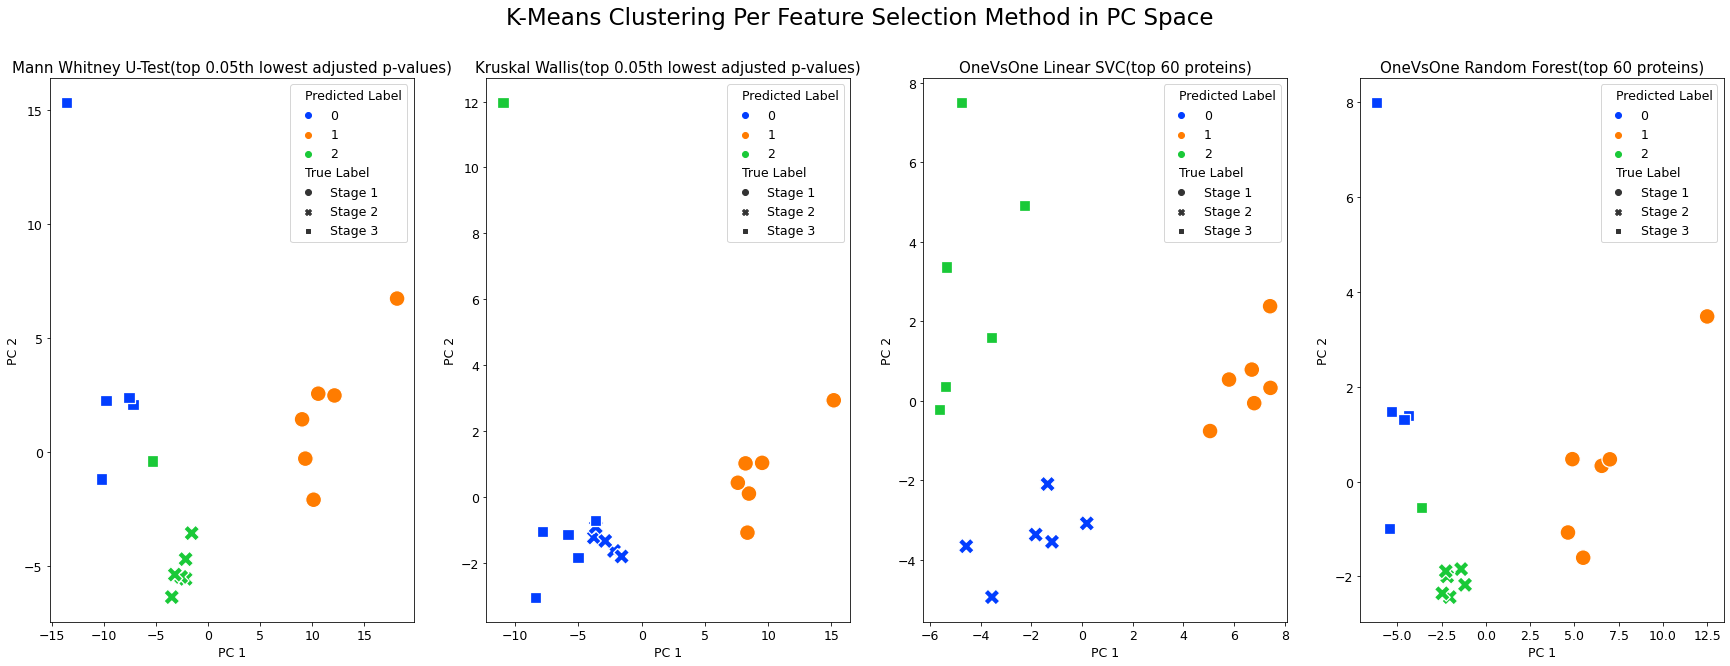

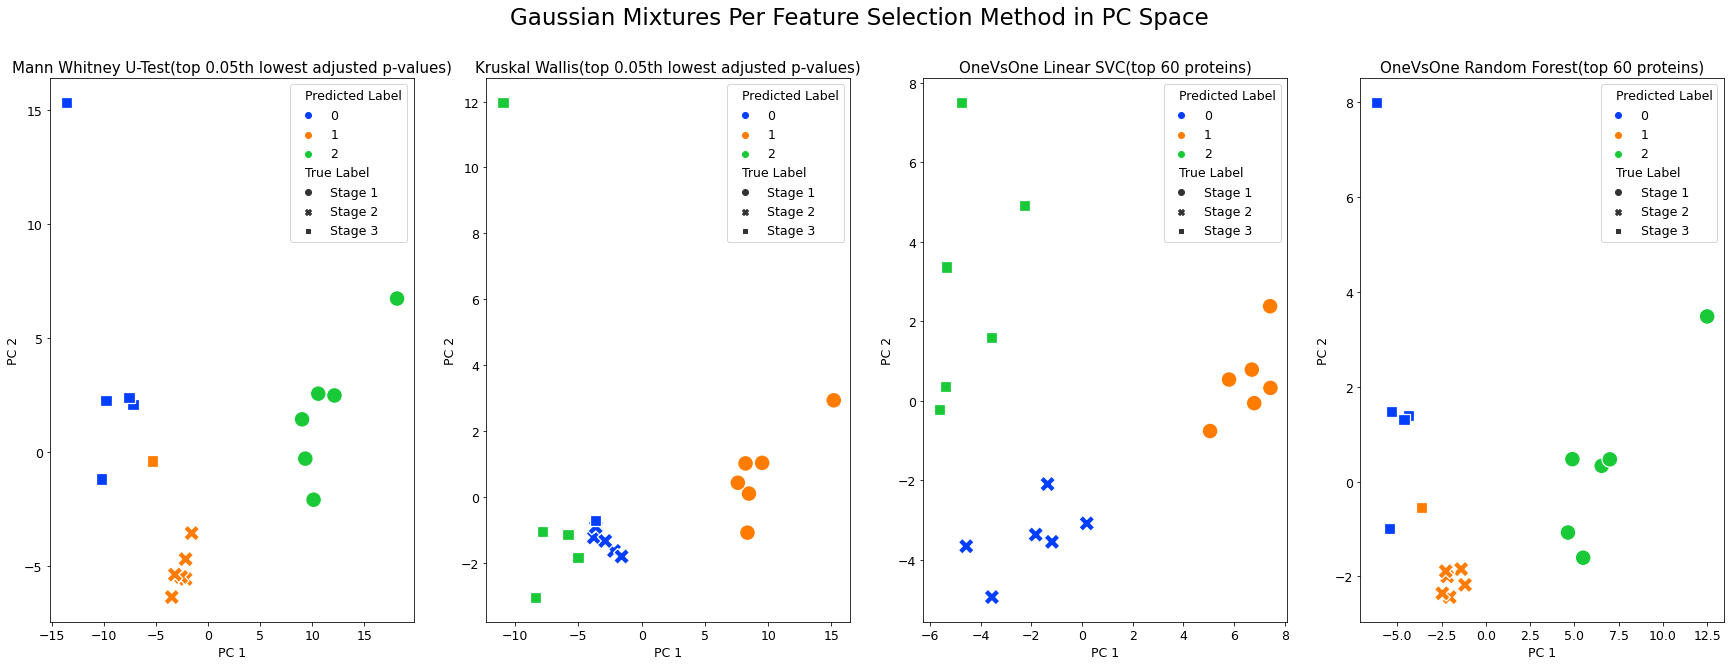

In [752]:
createPlots()

## 6. Optimal number of protein selection and sanity cheeck. Here, we will see if there is an optimal number of top features to select for the machine learning model based feature selection approaches or the statistical methods that use the top lowest quantile of p-values. We also want to confirm that adding more proteins will not necessarily lead to a better clustering or separation of classes after dimensionality reduction. We see adding more proteins, likely those that are not significant, leads to poorer clustering and representation of samples in PC Space. Gaussian Mixtures are still able to cluster into three groups, though misclassifications are seen in both statistical and machine learning based feature selection. Suppor Vector machines seem to be the best performing in terms of clustering and sample separation in PC space. We will use this model for downstream analysis to compare proteins implicative in bladder cancer progression.

In [778]:
def createPlotFun(df,featureSelectionMethod):
    
    methodDict = {}
    
    lowestPValQuantiles = [0.01,0.05,0.10,0.20]
    
    topNFeatures = [20,30,40,50]
    
    if featureSelectionMethod.__name__ in ["mannwhitneytest","kruskalWallis"]:
    
        for q in lowestPValQuantiles:
            methodDict["lowest"+" "+str(q)+"th quantile"] = featureSelectionMethod(df,q)
    
    else:
        
        for n in topNFeatures:
            methodDict["top"+" "+str(n*2)+" "+"proteins only"] = featureSelectionMethod(df,n)
    
    plt.rcParams['figure.figsize']=(200,500)
    plt.rcParams['legend.fontsize'] = 12.5
    plt.rcParams['font.size'] = 12.5
    
    fig, axs = plt.subplots(1, len(methodDict), figsize=(30, 10))
    i=0
    fig.suptitle("K-Means Clustering For"+" "+str(featureSelectionMethod.__name__)+" "+"Method in PC Space",fontsize=23)
    for k,v in methodDict.items():
        kMeansLabels = kMeans(v)
        plotClusters(k,df,v,kMeansLabels,axs[i])
        i += 1
        
    fig_1, axs_2 = plt.subplots(1, len(methodDict), figsize=(30, 10))
    j=0
    fig_1.suptitle("Gaussian Mixtures For"+" "+str(featureSelectionMethod.__name__)+" "+"Method in PC Space",fontsize=23)
    for k,v in methodDict.items():
        gmmLabelsLabels = gmmModel(v)
        plotClusters(k,df,v,gmmLabelsLabels,axs_2[j])
        j += 1

## 6.A. K Means and GMM for Mann Whitney U Test with different lowest quantile values

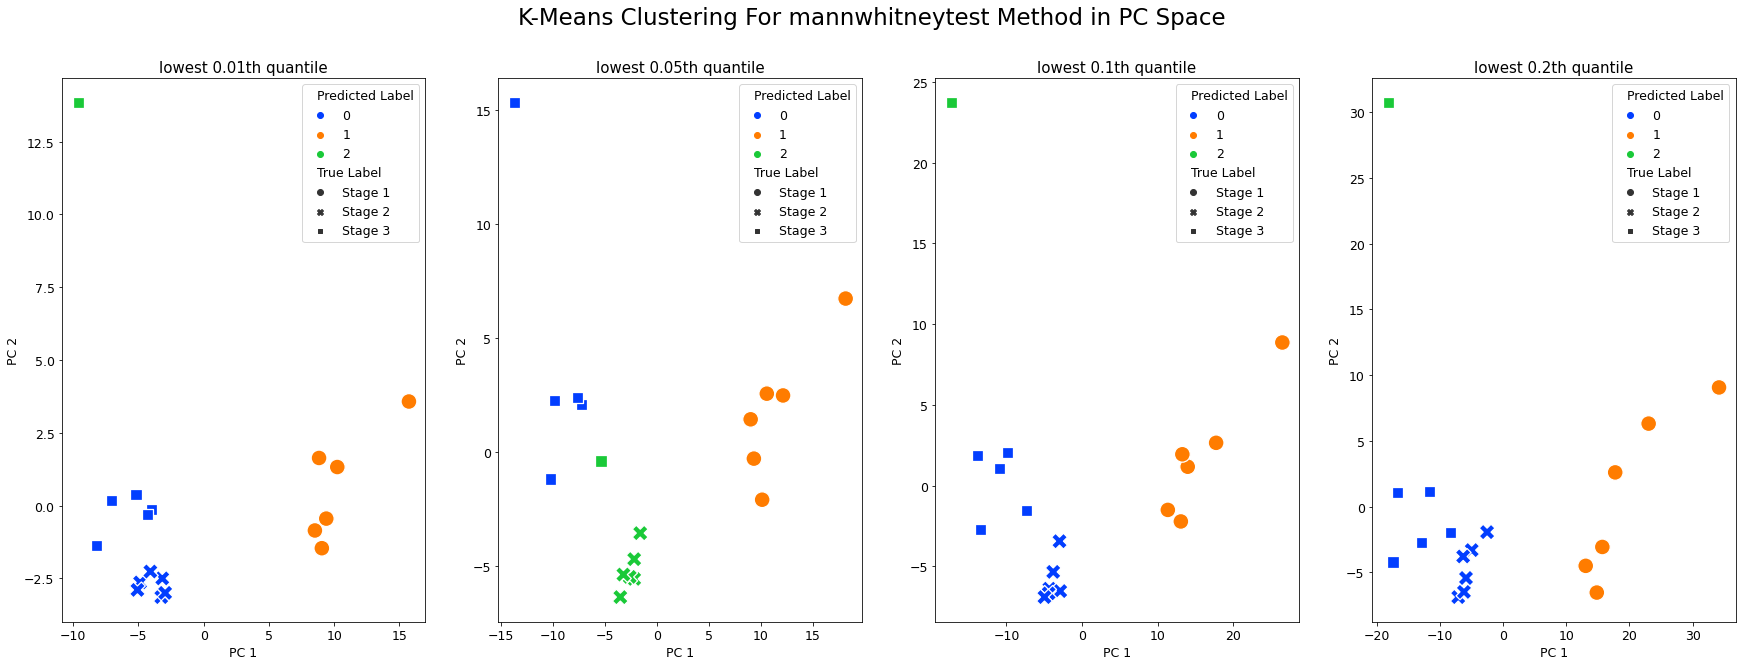

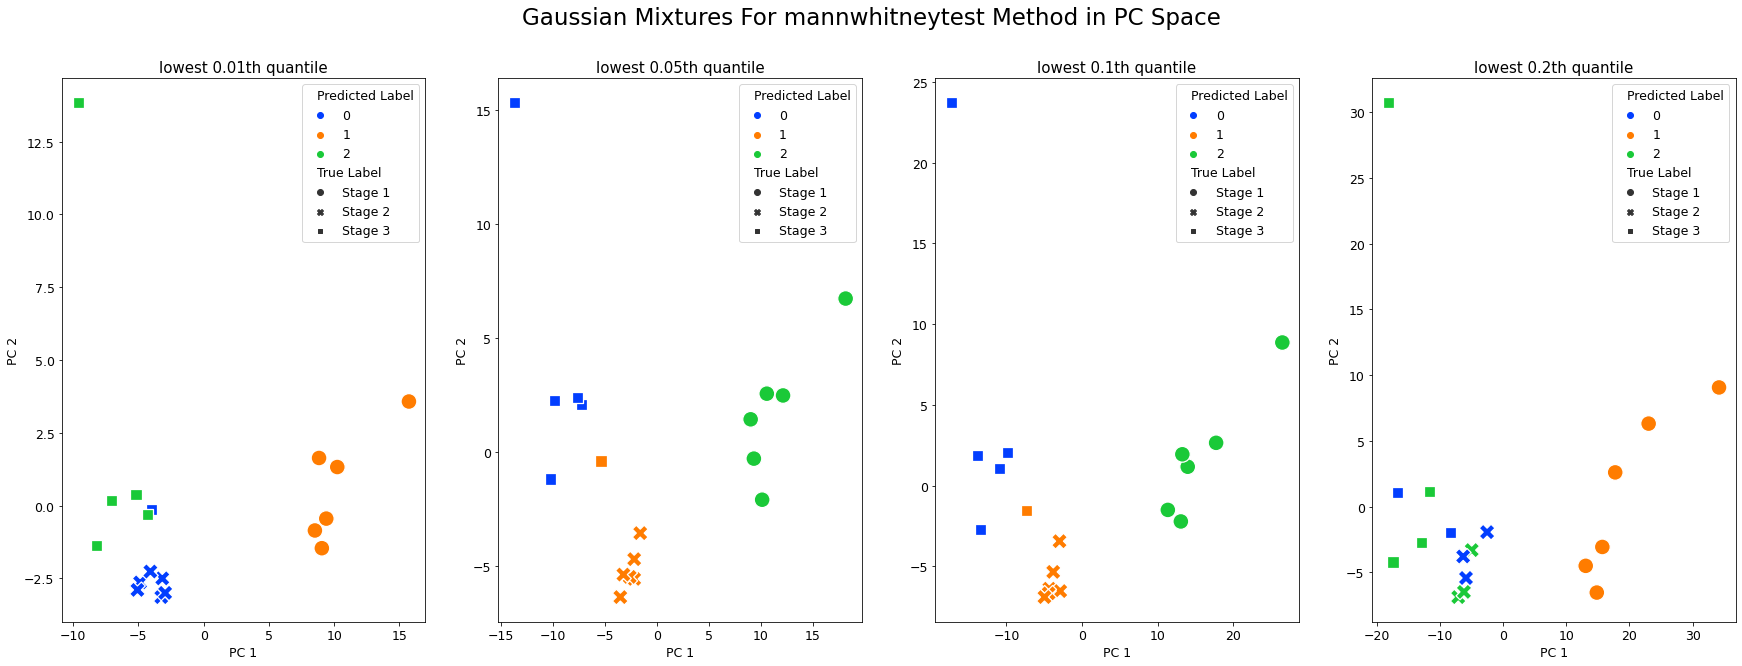

In [779]:
createPlotFun(df,mannwhitneytest)

## 6.B. K Means and GMM for Kruskal Wallis with different lowest quantile values

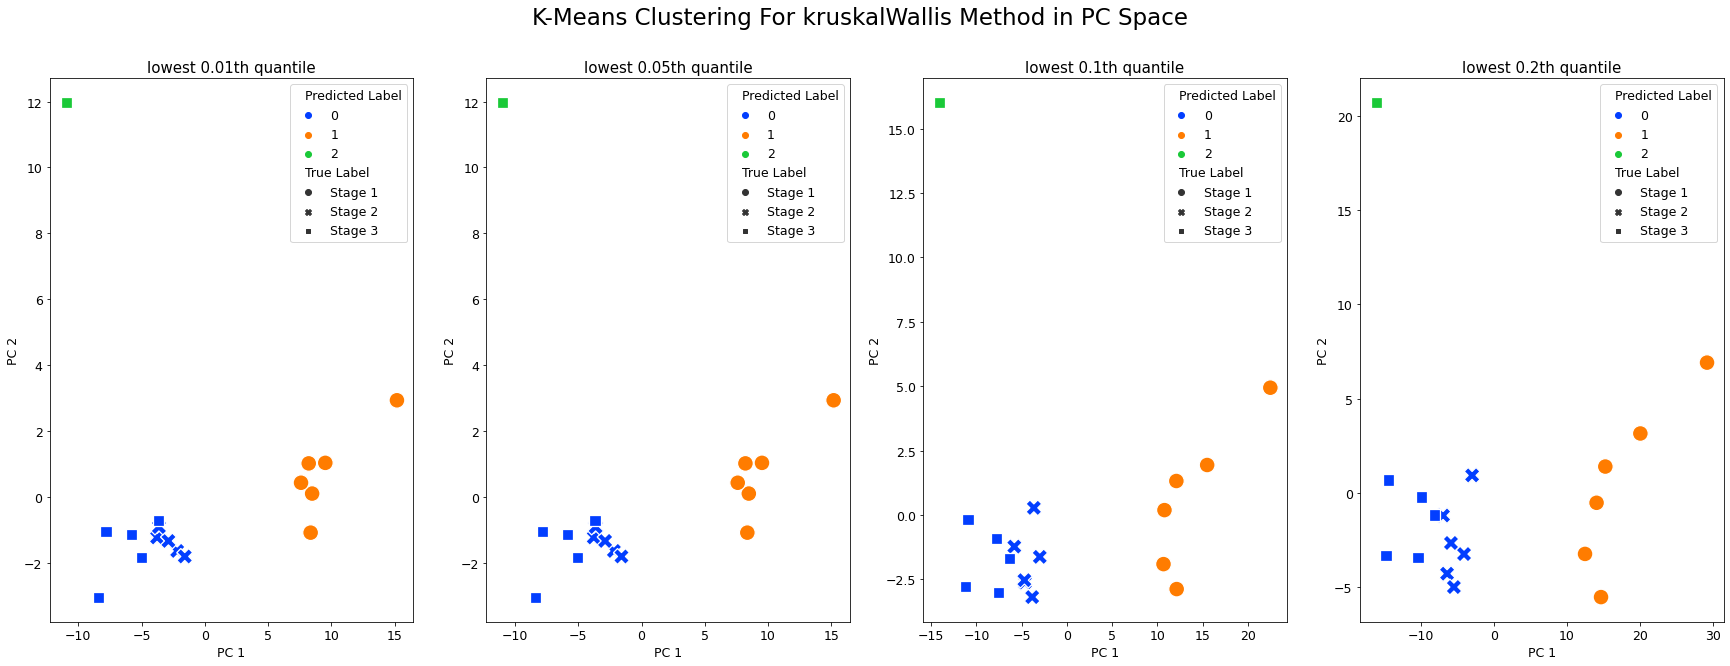

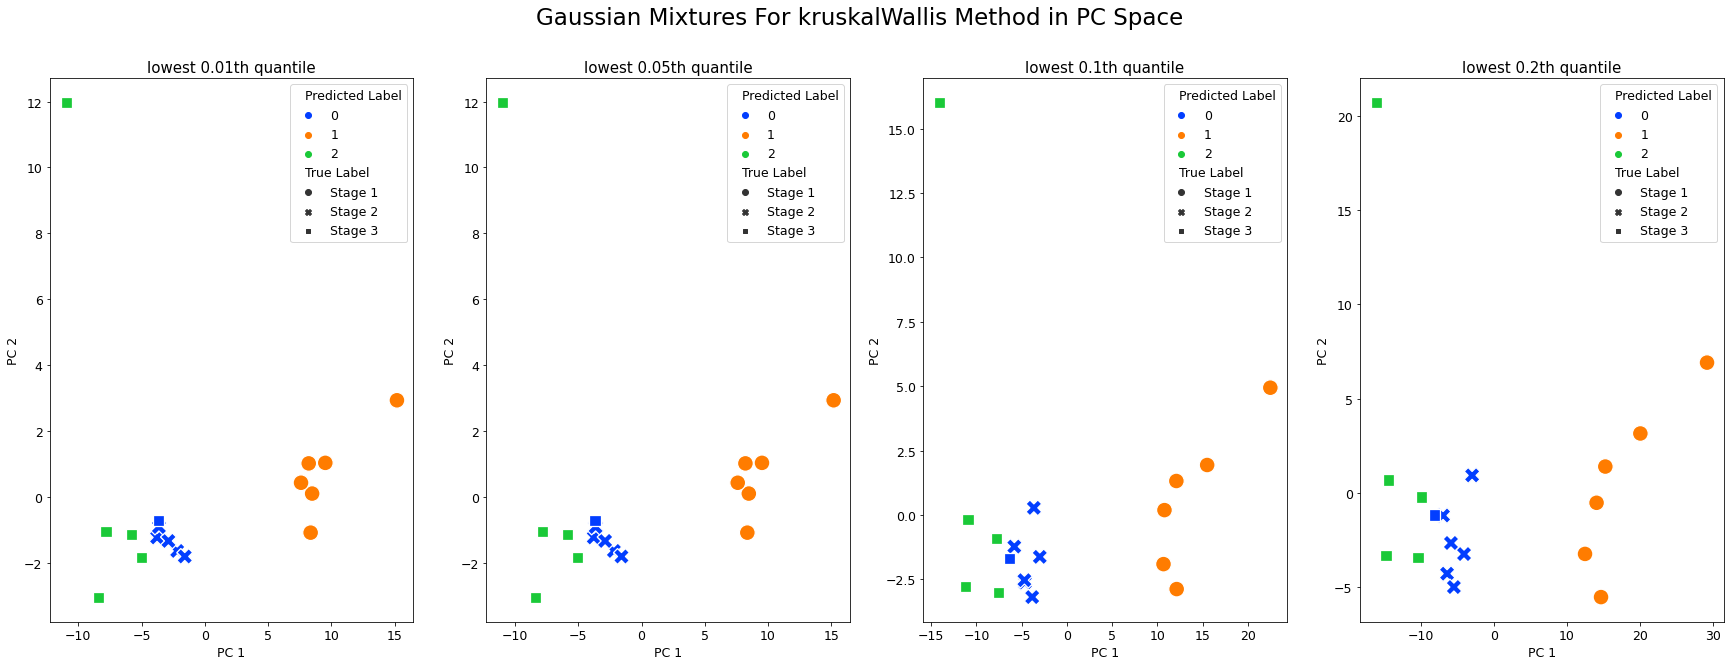

In [780]:
createPlotFun(df,kruskalWallis)

## 6.C. K Means and GMM for  One Vs One Linear Supper Vector Machines with different number of top proteins selected

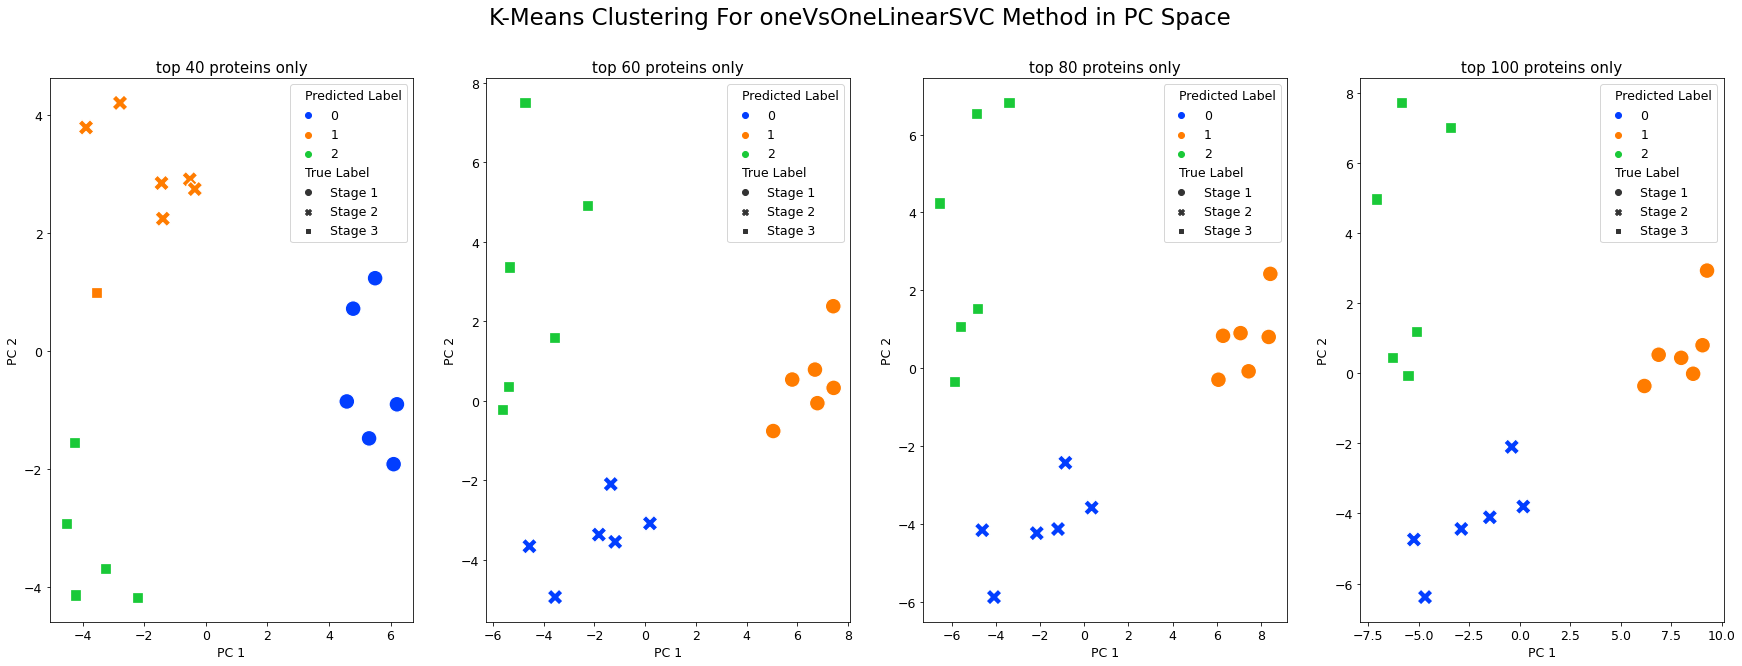

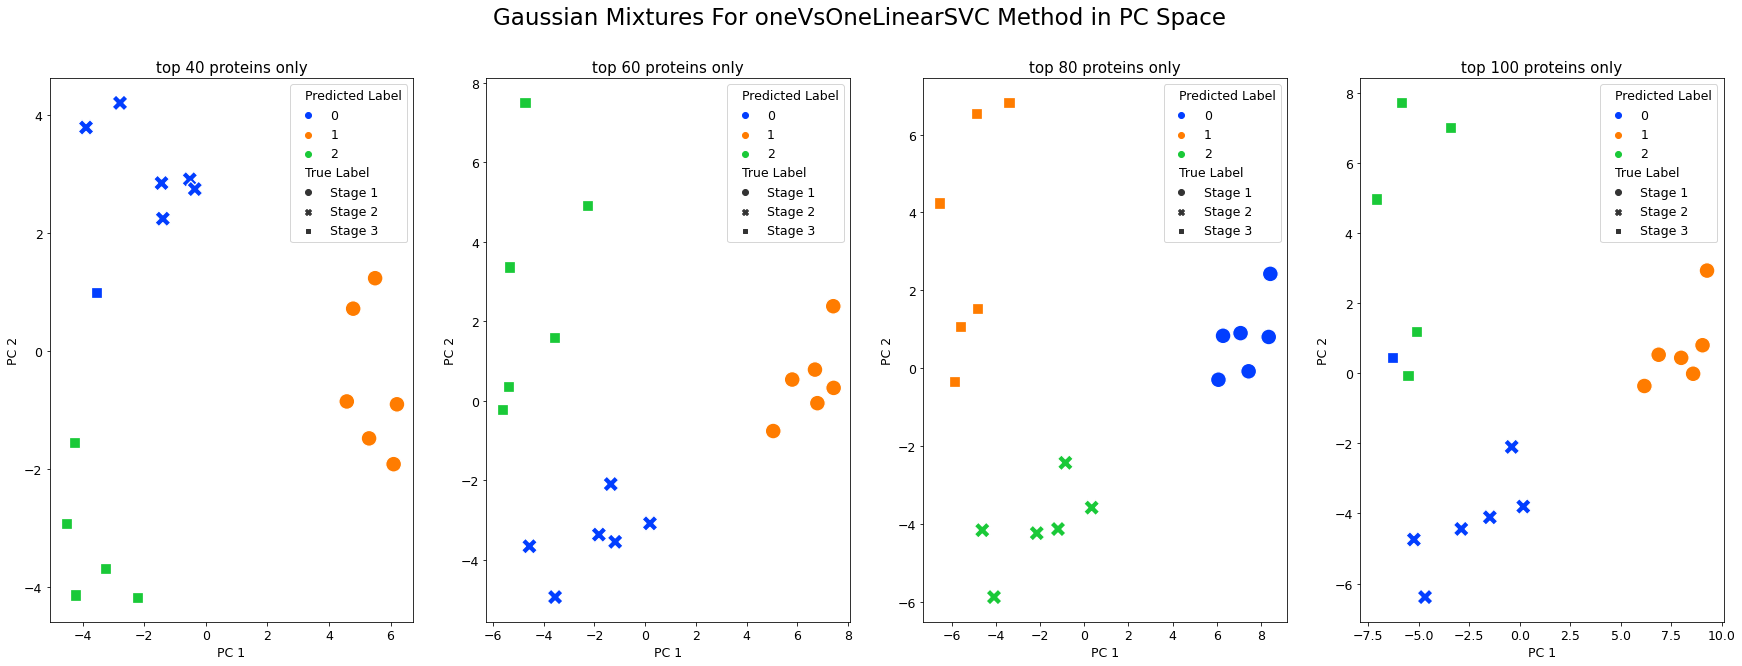

In [783]:
createPlotFun(df,oneVsOneLinearSVC)

## 6.D. K Means and GMM for  One Vs One Linear Supper Vector Machines with different number of top proteins selected

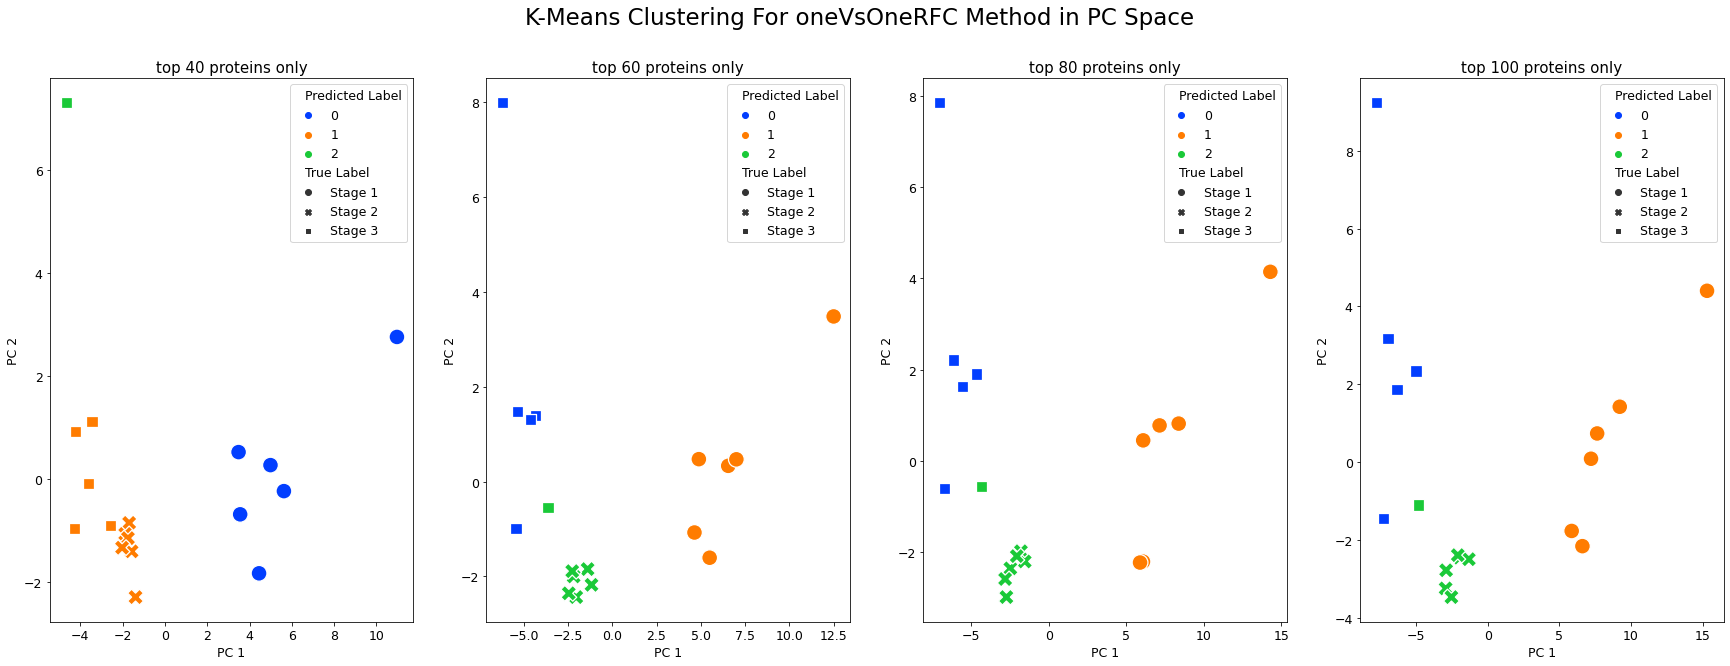

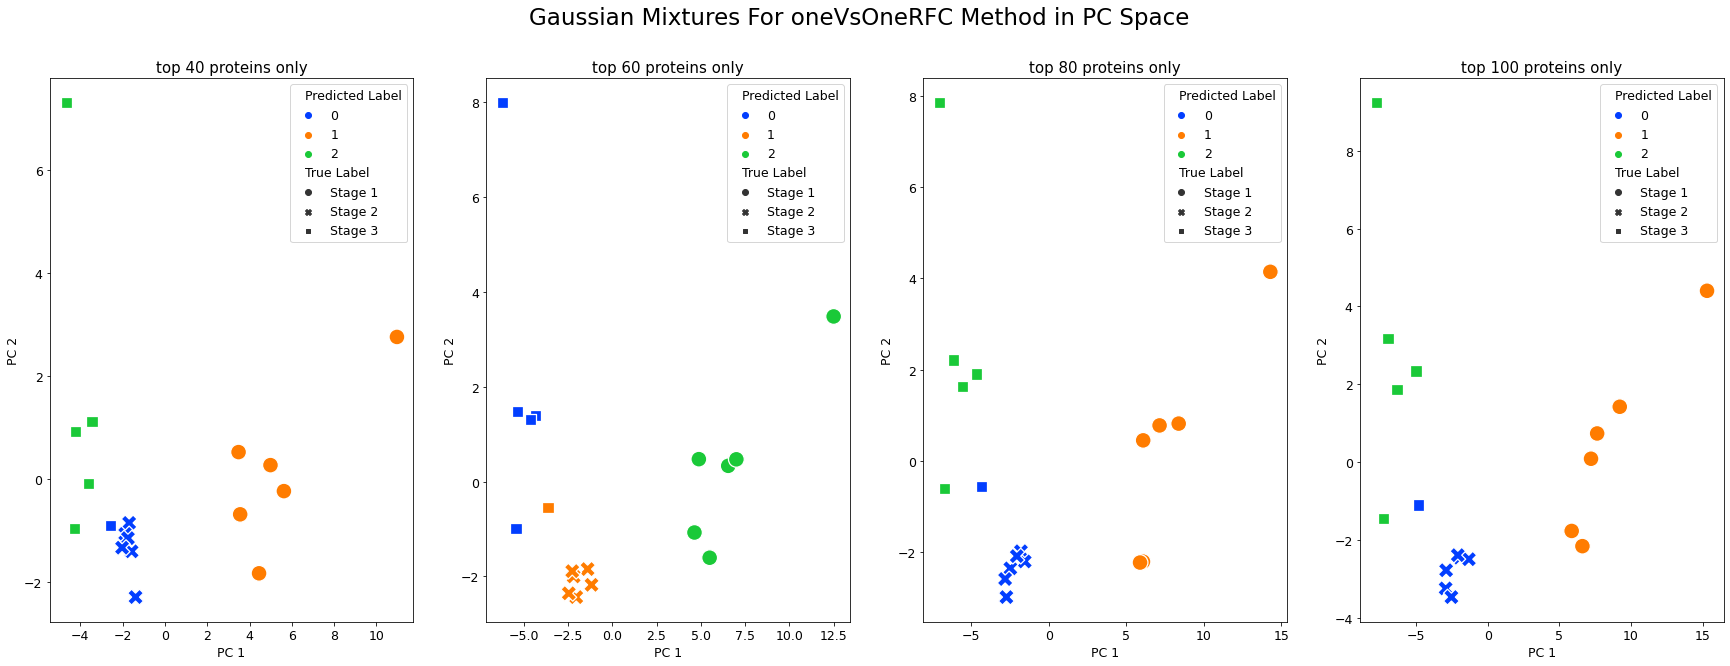

In [782]:
createPlotFun(df,oneVsOneRFC)

## 7. We will analyize the top proteins for each classification with Linear Support Vector classifer, that is, the top proteins distinguishing stage 1 from stage 2, and top proteins distinguishing stage 2 from stage 3. 

In [791]:
def oneVsOneLinearSVCGetProteins(df,nFeatures):

    grade1vs2 = df[df["Class"].isin(["Stage 1","Stage 2"])]
    grade1vs2Vars,grade1vs2Labels = grade1vs2.iloc[:,:-1],grade1vs2.iloc[:,-1]

    svc1 = SVC(kernel="linear").fit(grade1vs2Vars,grade1vs2Labels)

    sortedProteinsSVC1 = sorted(list(zip(grade1vs2.columns,svc1.coef_[0])),key=lambda x: x[1],reverse=True)

    grade2vs3 = df[df["Class"].isin(["Stage 2","Stage 3"])]
    grade2vs3Vars,grade2vs3Labels = grade2vs3.iloc[:,:-1],grade2vs3.iloc[:,-1]

    svc2 = SVC(kernel="linear").fit(grade2vs3Vars,grade2vs3Labels)

    sortedProteinsSVC2 = sorted(list(zip(grade2vs3.columns,svc2.coef_[0])),key=lambda x: x[1],reverse=True)
        
    grade1vs2TopProteins = [i[0] for i in sortedProteinsSVC1[:nFeatures]]
    grade2vs3TopProteins = [i[0] for i in sortedProteinsSVC2[:nFeatures]]
    
    
    return grade1vs2TopProteins,grade2vs3TopProteins

In [793]:
grade1vs2Proteins,grade2vs3Proteins = oneVsOneLinearSVCGetProteins(df,5)

In [802]:
dfFilt = df.loc[:,grade1vs2Proteins+grade2vs3Proteins]
dfFilt["Class"] = df["Class"]

In [814]:
dfFiltMelt = pd.melt(dfFilt, id_vars=['Class'], value_vars=list(dfFilt.columns[:-1]))
dfFiltMelt = dfFiltMelt.rename(columns={"variable": "Protein", "value": "Standardized Expression"})

## 7.A.  Top Scoring Protein Expression Distribution Per Cancer Stage

Text(0.5, 1.1, 'Distribution of Protein Expression Per Cancer Stage')

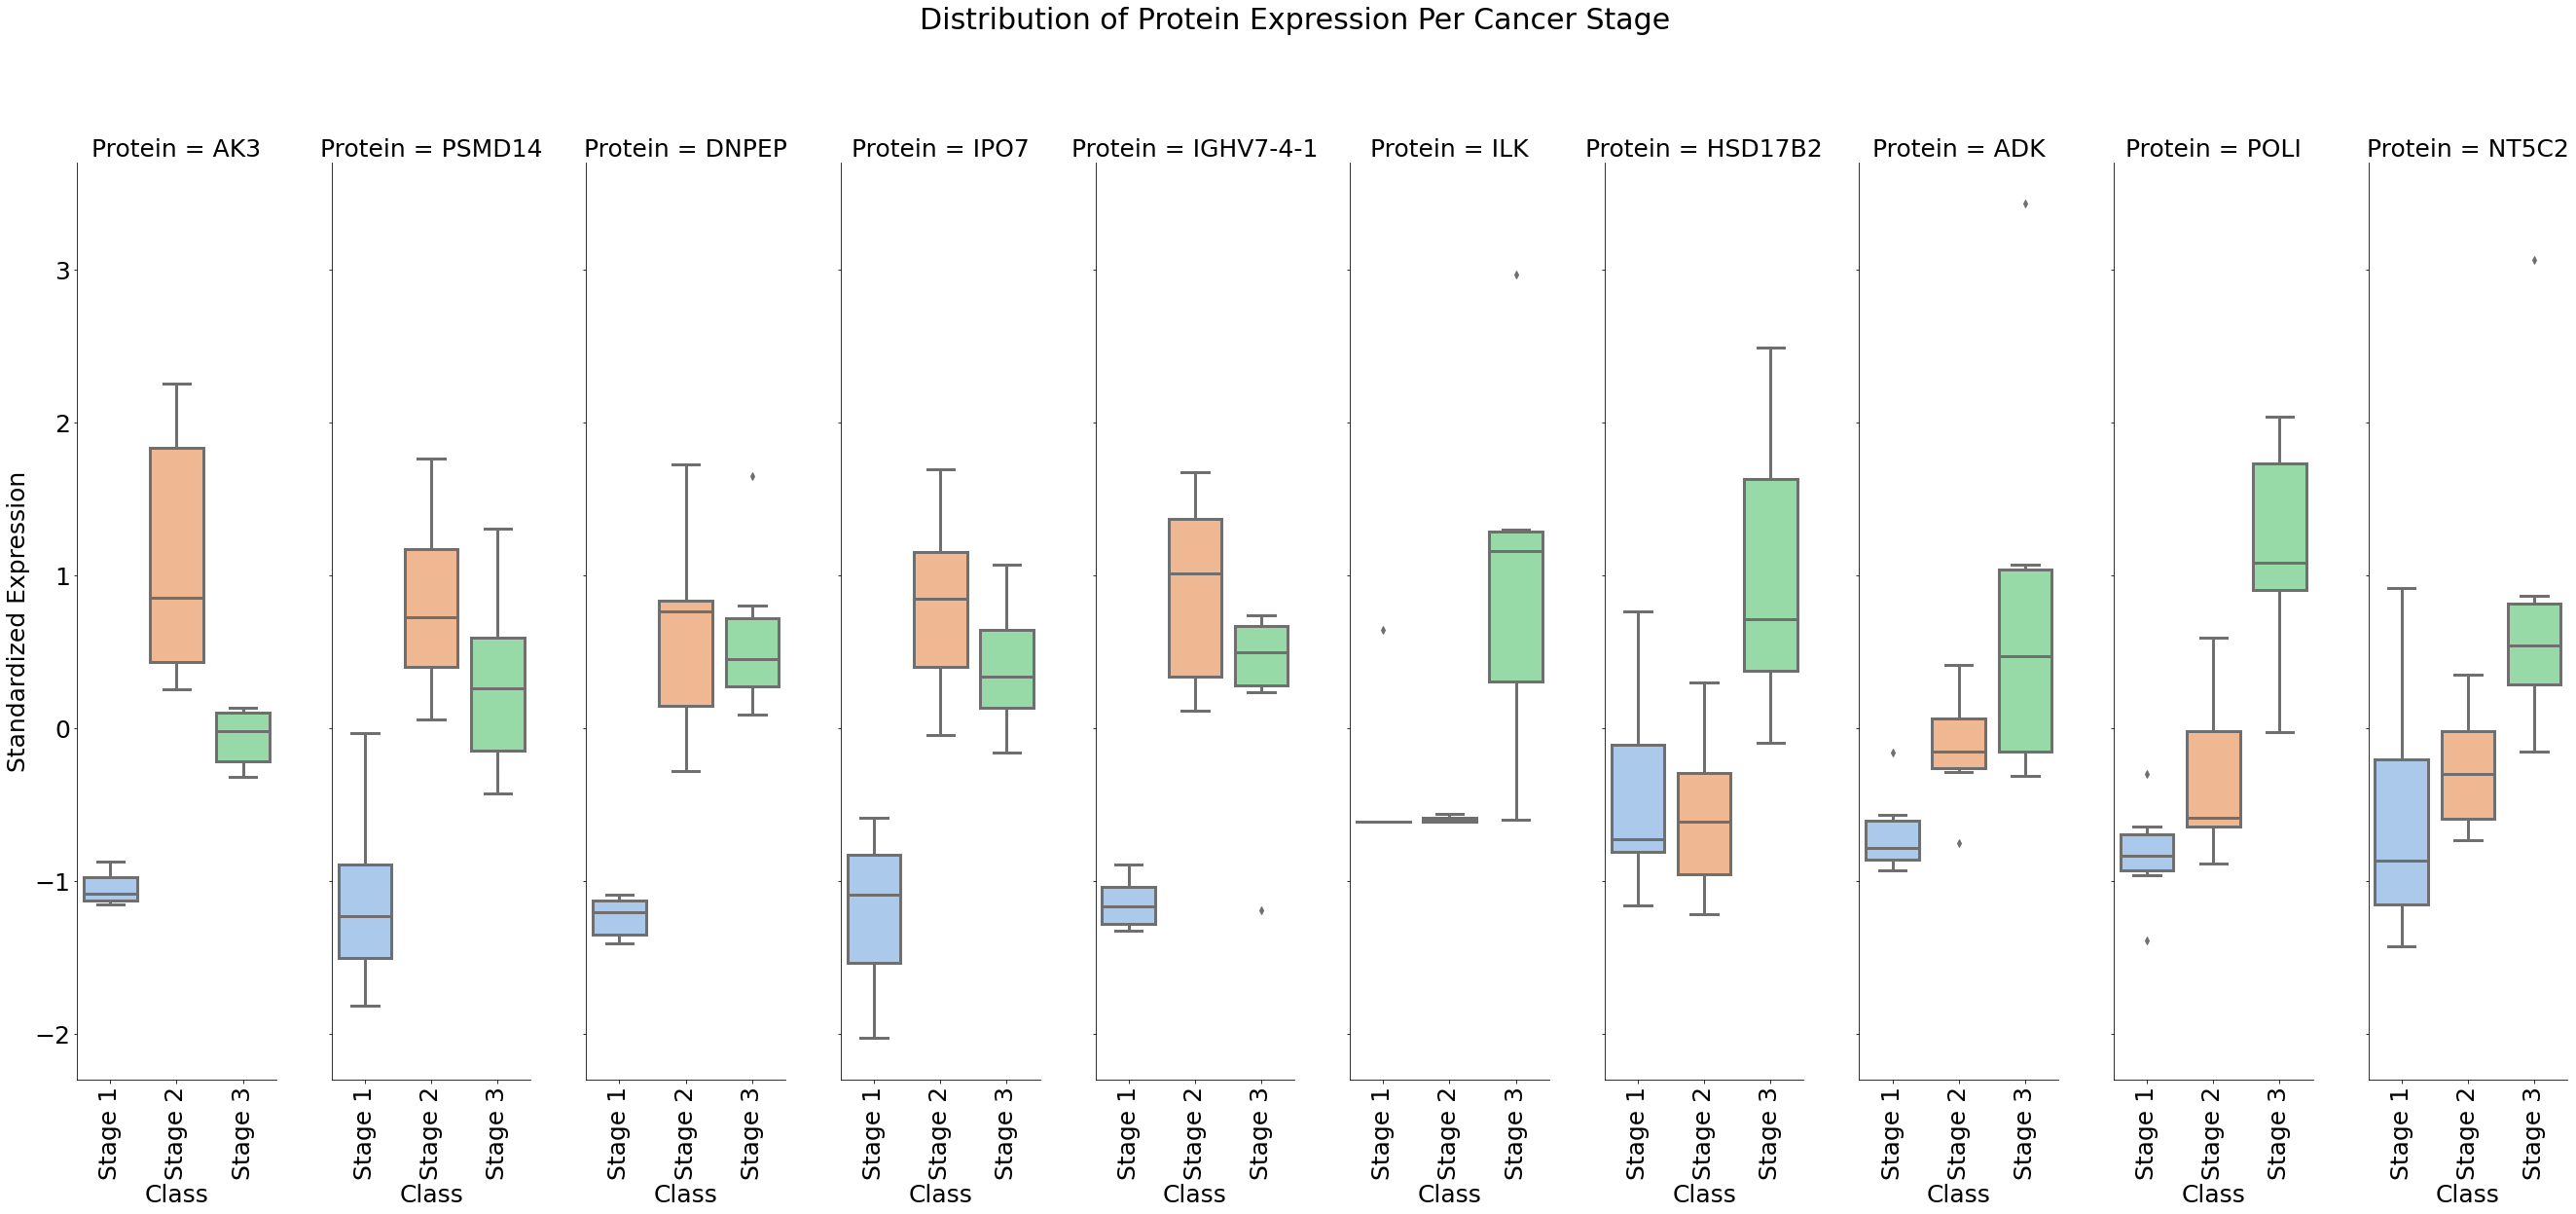

In [878]:
plt.rcParams['figure.figsize']=(25,25)
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['font.size'] = 25
g=sns.catplot(data=dfFiltMelt,col="Protein",y="Standardized Expression",x="Class",
            kind="box",height=15, aspect=0.25,linewidth=3)
g.set_axis_labels(fontsize=46, fontweight="bold")
xtick_labels = g.axes.flat[-1].get_xticklabels()
g.set_xticklabels(xtick_labels, rotation=90)
g.fig.suptitle("Distribution of Protein Expression Per Cancer Stage",y=1.1)

## 7.B.  Relationship between the Top 6 Scoring Proteins with respect to Cancer Stage 

<ipython-input-879-aad1c6d26849>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFiltTop3["Class"] = dfFilt["Class"]


Text(0.5, 1.05, 'Relationship of Top 6 Proteins Per Cancer Stage')

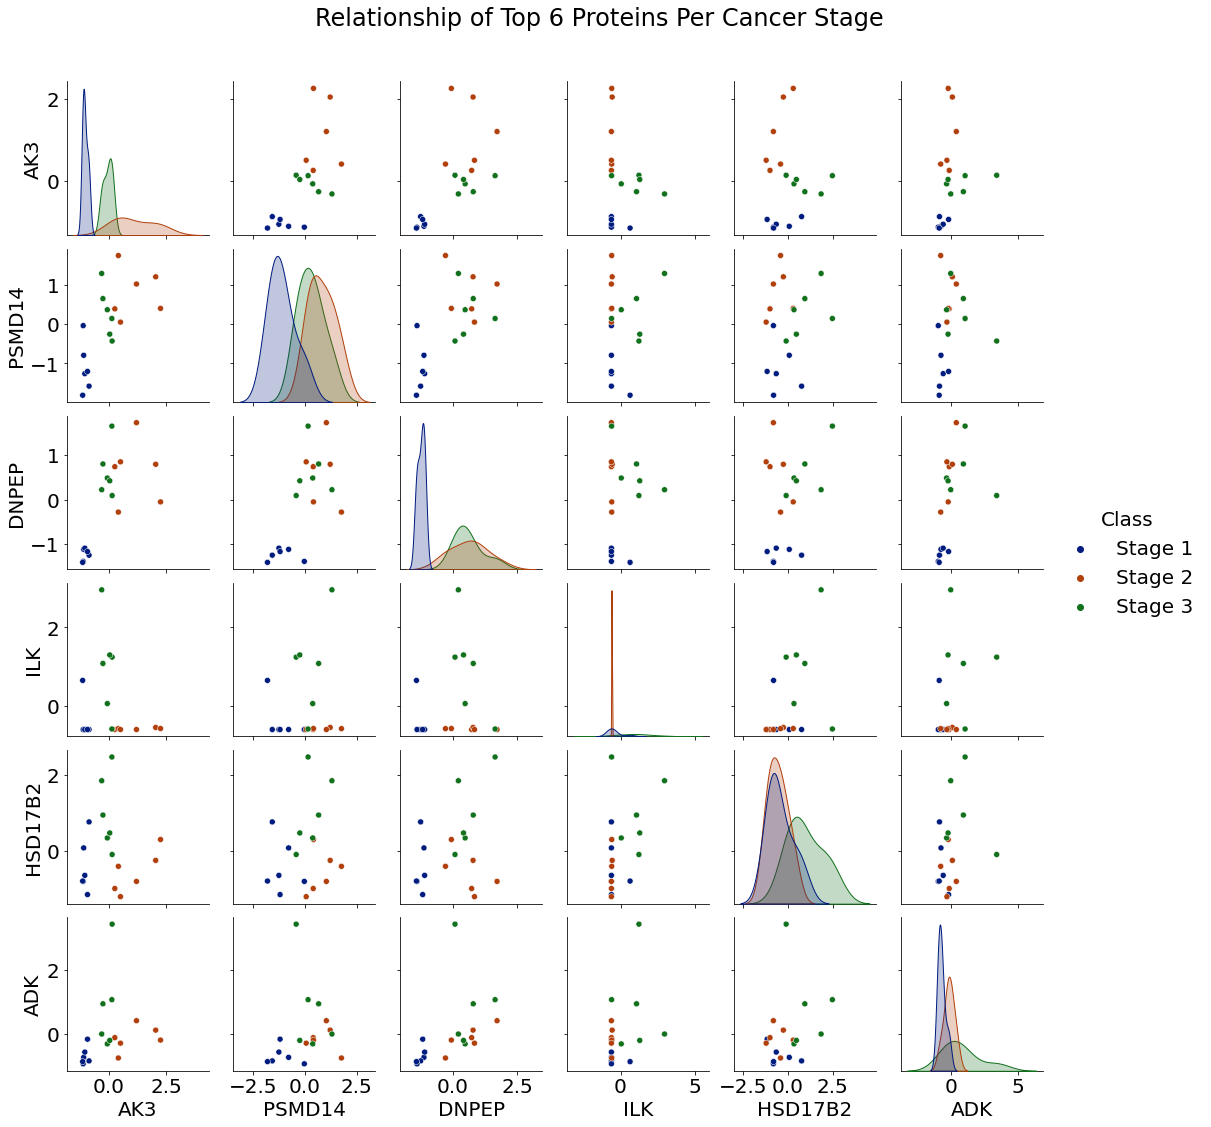

In [879]:
plt.rcParams['figure.figsize']=(25,25)
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['font.size'] = 20

dfFiltTop3 = dfFilt[list(dfFilt.columns[:3])+list(dfFilt.columns[5:8])]
dfFiltTop3["Class"] = dfFilt["Class"]

pp=sns.pairplot(dfFiltTop3,hue="Class",palette="dark")
pp.fig.suptitle("Relationship of Top 6 Proteins Per Cancer Stage",y=1.05)

In [884]:
top10grade1vs2Proteins,top10grade2vs3Proteins = oneVsOneLinearSVCGetProteins(df,10)
dfFiltTop20 = df.loc[:,top10grade1vs2Proteins+top10grade2vs3Proteins]
dfFiltTop20["Class"] = df["Class"]

## 7.C.  Sample Relationships with the Top 20 Scoring Proteins 

Text(0.5, 1.0, 'Sample Relationship with Top 20 Proteins')

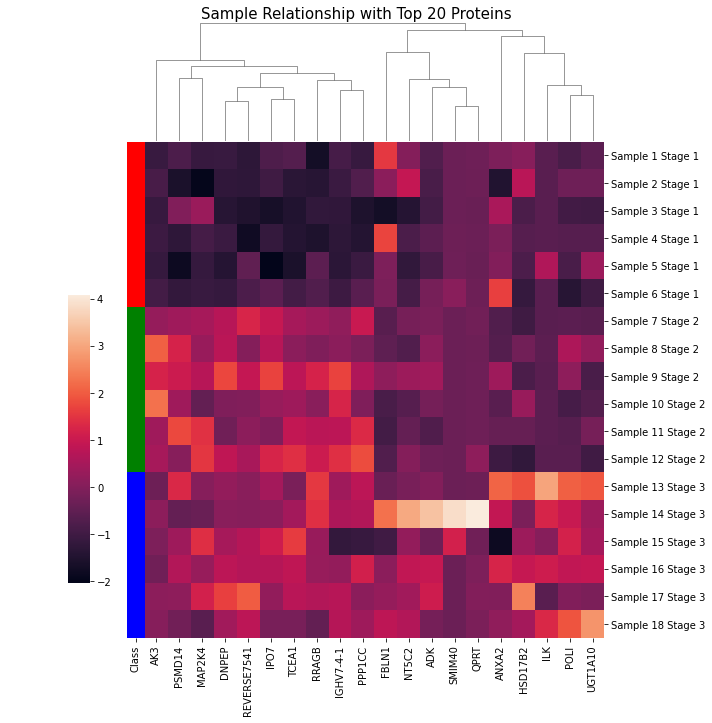

In [948]:
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 10

class_order = ["Stage 1", "Stage 2", "Stage 3"]

lut = dict(zip(class_order, "rgb"))

colors = dfFiltTop20["Class"].map(lut)

cm=sns.clustermap(dfFiltTop20.iloc[:,:-1],row_colors=colors,
                  row_cluster=False,cbar_pos=(0.1, 0.2, 0.03, 0.4))
cm.fig.suptitle("Sample Relationship with Top 20 Proteins",y=1.0,size=15)